# Food Delivery Order Cancellation Analysis

**Analysis Report**  

---

## Executive Summary

This analysis investigates **why orders are getting cancelled** in a food delivery platform operating in India. The goal is to identify patterns and factors that lead to cancellations and provide actionable recommendations.

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the data
subs = pd.read_csv("loyalty_supp.csv")
orders = pd.read_csv("main.csv")

print(f"Orders shape: {orders.shape}")
print(f"Subscriptions shape: {subs.shape}")
print("\nFirst few rows of orders:")
orders.head()

Orders shape: (517773, 19)
Subscriptions shape: (69837, 4)

First few rows of orders:


,Unnamed: 0,Customer_Key,Order_Key,order_source,created_at,dispatch_time,actual_delivery_time,bill_amount,cart_amount,coupon_id,delivery_fee,store_key,delivery_city,pdt,Store_lat,Store_long,delivery_location_latitude,delivery_location_longitude,pay_mode_grouped
0,1,CUST_1,ORD_1,Mobile,2024-03-01T03:33:35,NaN,NaN,263,199.0,8043589.0,29.40,STORE_1,CITY_1,45.0,28.623269,77.035176,28.630476,77.029983,Credit/BNPL
1,2,CUST_2,ORD_2,Mobile,2024-03-01T03:55:46,2024-03-01T04:12:56,2024-03-01T04:22:16,341,417.0,7670379.0,9.45,STORE_2,CITY_2,45.0,28.462377,77.080403,28.460245,77.083425,UPI
2,3,CUST_3,ORD_3,Mobile,2024-03-01T04:37:43,2024-03-01T04:47:54,2024-03-01T04:59:28,180,228.0,7987325.0,0.00,STORE_3,CITY_1,39.0,28.633497,77.281993,28.625607,77.299079,Credit/BNPL
3,4,CUST_4,ORD_4,Mobile,2024-03-01T04:37:58,2024-03-01T04:56:32,2024-03-01T05:20:58,541,557.0,7987325.0,0.00,STORE_4,CITY_1,45.0,28.566044,77.197894,28.580365,77.206151,UPI
4,5,CUST_5,ORD_5,Mobile,2024-03-01T04:40:33,NaN,NaN,238,219.0,8043589.0,0.00,STORE_5,CITY_3,45.0,28.390421,77.306137,28.365680,77.298400,UPI


In [3]:
subs.head()

,Unnamed: 0,customer_id,start_date,end_date
0,1,CUST_96111,2023-08-11 09:19:30,2023-11-09 09:19:30
1,2,CUST_141968,2023-08-14 20:40:21,2024-02-10 20:40:21
2,3,CUST_26499,2023-08-16 14:37:50,2023-11-14 14:37:50
3,4,CUST_174326,2023-08-17 06:41:12,2023-08-24 06:41:12
4,5,CUST_97908,2023-08-17 07:54:09,2023-11-15 07:54:09


## 2. Data Preparation

In [4]:
# Convert timestamps to datetime
orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['dispatch_time'] = pd.to_datetime(orders['dispatch_time'])
orders['actual_delivery_time'] = pd.to_datetime(orders['actual_delivery_time'])

# Create cancellation indicator
orders['is_cancelled'] = (orders['dispatch_time'].isna()) & (orders['actual_delivery_time'].isna())

# Extract time components
orders['order_hour'] = orders['created_at'].dt.hour
orders['order_day'] = orders['created_at'].dt.day_name()
orders['order_date'] = orders['created_at'].dt.date

# Loyalty customer indicator (delivery_fee = 0)
orders['is_loyalty'] = (orders['delivery_fee'] == 0)

# Coupon usage indicator
orders['used_coupon'] = orders['coupon_id'].notna() & (orders['coupon_id'] != '')

# Calculate discount amount
orders['discount_amount'] = orders['cart_amount'] - orders['bill_amount'] + orders['delivery_fee']

# Calculate Manhattan distance
orders['manhattan_distance'] = (abs(orders['Store_lat'] - orders['delivery_location_latitude']) + 
                                abs(orders['Store_long'] - orders['delivery_location_longitude']))

# Create distance buckets based on percentiles
distance_percentiles = orders['manhattan_distance'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0])
orders['distance_bucket'] = pd.cut(orders['manhattan_distance'], 
                                   bins=distance_percentiles,
                                   labels=['Very Close (0-20%)', 'Close (20-40%)', 
                                          'Medium (40-60%)', 'Far (60-80%)', 
                                          'Very Far (80-100%)'],
                                   include_lowest=True)

# Create PDT buckets
orders['pdt_bucket'] = pd.cut(orders['pdt'], 
                             bins=[0, 30, 40, 50, 60, np.inf],
                             labels=['≤30min', '31-40min', '41-50min', '51-60min', '>60min'],
                             include_lowest=True)

# Create delivery fee buckets
orders['delivery_fee_bucket'] = pd.cut(orders['delivery_fee'], 
                                       bins=[-0.01, 0, 20, 40, 60, np.inf],
                                       labels=['Free (0)', '1-20', '21-40', '41-60', '>60'],
                                       include_lowest=True)

# Order status for visualization
orders['order_status'] = orders['is_cancelled'].map({True: 'Cancelled', False: 'Delivered'})

print("Data Preparation Complete!")
print(f"Total Orders: {len(orders):,}")
print(f"Cancelled Orders: {orders['is_cancelled'].sum():,}")
print(f"Cancellation Rate: {orders['is_cancelled'].mean() * 100:.2f}%")

Data Preparation Complete!
Total Orders: 517,773
Cancelled Orders: 86,892
Cancellation Rate: 16.78%


In [5]:
# Merge with subscription data
subs['start_date'] = pd.to_datetime(subs['start_date'])
subs['end_date'] = pd.to_datetime(subs['end_date'])

orders_full = orders.merge(subs, left_on='Customer_Key', right_on='customer_id', how='left')
print(f"Merged dataset shape: {orders_full.shape}")

Merged dataset shape: (571528, 35)


## 3. Overall Cancellation Summary

In [6]:
cancellation_summary = pd.DataFrame({
    'Metric': ['Total Orders', 'Cancelled Orders', 'Delivered Orders', 'Cancellation Rate (%)'],
    'Value': [
        f"{len(orders):,}",
        f"{orders['is_cancelled'].sum():,}",
        f"{(~orders['is_cancelled']).sum():,}",
        f"{orders['is_cancelled'].mean() * 100:.2f}%"
    ]
})

print("\n=== OVERALL CANCELLATION SUMMARY ===")
print(cancellation_summary.to_string(index=False))


=== OVERALL CANCELLATION SUMMARY ===
               Metric   Value
         Total Orders 517,773
     Cancelled Orders  86,892
     Delivered Orders 430,881
Cancellation Rate (%)  16.78%


## 4. Temporal Analysis

### 4.1 Cancellation by Hour of Day

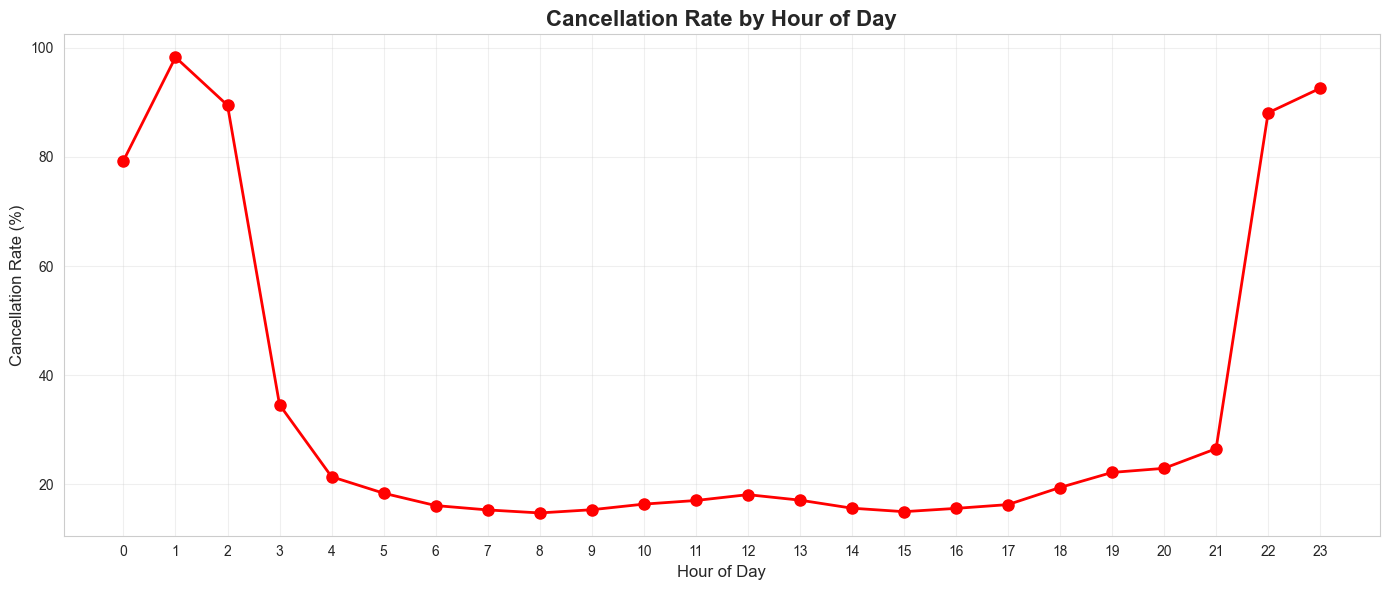


Top 10 hours with highest cancellation rates:
    order_hour  cancellation_rate  total_orders
1            1          98.275862           232
23          23          92.592593            27
2            2          89.473684           399
22          22          88.095238           126
0            0          79.310345            29
3            3          34.589800           902
21          21          26.535819          5095
20          20          22.936605         12225
19          19          22.184002         19478
4            4          21.396104          3080


In [7]:
cancellation_by_hour = orders.groupby('order_hour').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_hour.columns = ['order_hour', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_hour['cancellation_rate'] *= 100

plt.figure(figsize=(14, 6))
plt.plot(cancellation_by_hour['order_hour'], cancellation_by_hour['cancellation_rate'], 
         marker='o', linewidth=2, markersize=8, color='red')
plt.title('Cancellation Rate by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 hours with highest cancellation rates:")
print(cancellation_by_hour.nlargest(10, 'cancellation_rate')[['order_hour', 'cancellation_rate', 'total_orders']])

### 4.2 Cancellation by Day of Week

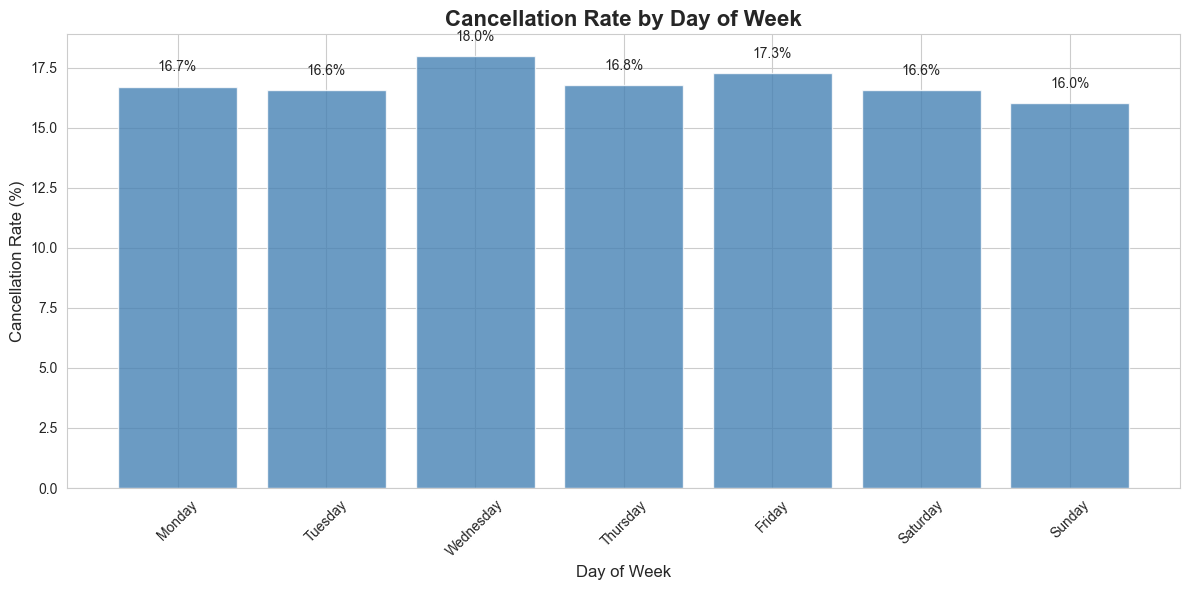

   order_day  cancelled  total_orders  cancellation_rate
1     Monday      12473         74634          16.712222
5    Tuesday       9001         54378          16.552650
6  Wednesday      11473         63813          17.979095
4   Thursday       9504         56666          16.771962
0     Friday      13633         78967          17.264174
2   Saturday      14915         90041          16.564676
3     Sunday      15893         99274          16.009227


In [8]:
# Order days correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

cancellation_by_day = orders.groupby('order_day').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_day.columns = ['order_day', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_day['cancellation_rate'] *= 100
cancellation_by_day['order_day'] = pd.Categorical(cancellation_by_day['order_day'], 
                                                   categories=day_order, ordered=True)
cancellation_by_day = cancellation_by_day.sort_values('order_day')

plt.figure(figsize=(12, 6))
bars = plt.bar(cancellation_by_day['order_day'], cancellation_by_day['cancellation_rate'], 
               color='steelblue', alpha=0.8)
plt.title('Cancellation Rate by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)

# Add value labels on bars
for i, (bar, rate) in enumerate(zip(bars, cancellation_by_day['cancellation_rate'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(cancellation_by_day)

In [9]:
import scipy.stats as stats

# Create a contingency table: rows=days, columns=[cancelled, not_cancelled]
contingency = orders.groupby('order_day')['is_cancelled'].value_counts().unstack(fill_value=0)
# Ensure all days are present in the index
contingency = contingency.reindex(day_order, fill_value=0)

chi2, p, dof, expected = stats.chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("There is a significant difference in cancellation rates across days of the week.")
else:
    print("No significant difference in cancellation rates across days of the week.")

Chi-square statistic: 126.43
p-value: 0.0000
There is a significant difference in cancellation rates across days of the week.


### 4.3 Cancellation Trend Over Time

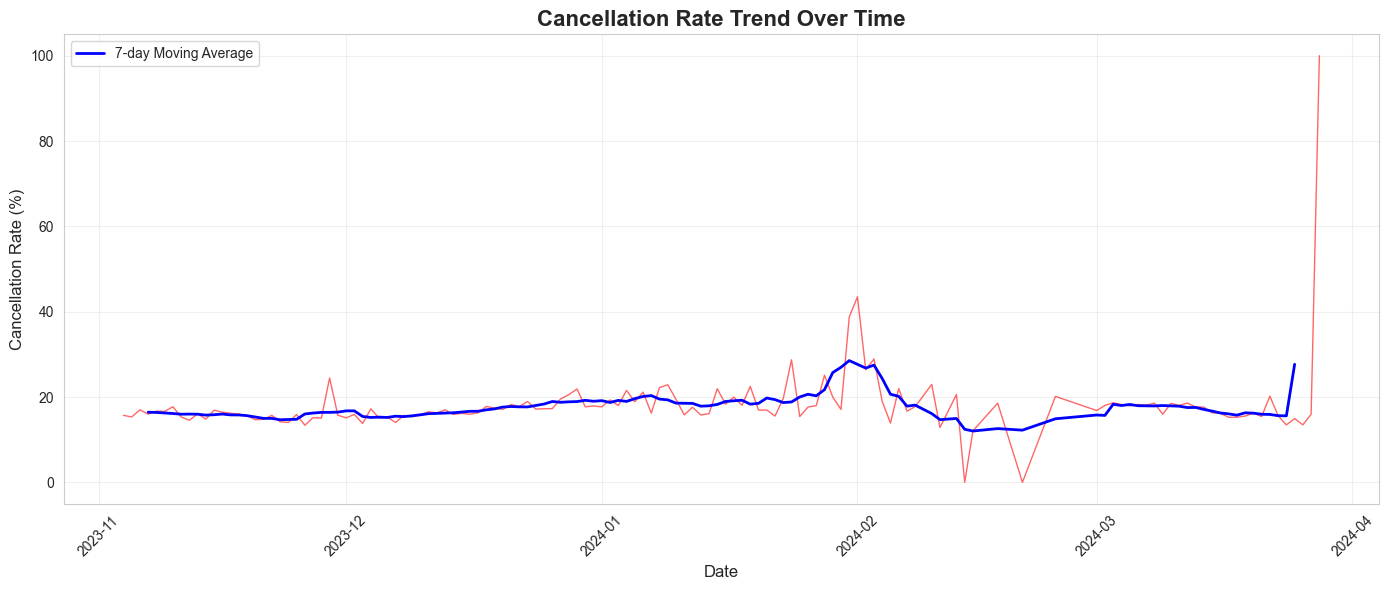

In [10]:
cancellation_trend = orders.groupby('order_date').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_trend.columns = ['order_date', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_trend['cancellation_rate'] *= 100

plt.figure(figsize=(14, 6))
plt.plot(cancellation_trend['order_date'], cancellation_trend['cancellation_rate'], 
         alpha=0.6, color='red', linewidth=1)

# Add rolling average
cancellation_trend['rolling_avg'] = cancellation_trend['cancellation_rate'].rolling(window=7, center=True).mean()
plt.plot(cancellation_trend['order_date'], cancellation_trend['rolling_avg'], 
         color='blue', linewidth=2, label='7-day Moving Average')

plt.title('Cancellation Rate Trend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Geographic Analysis

### 5.1 Cancellation by City

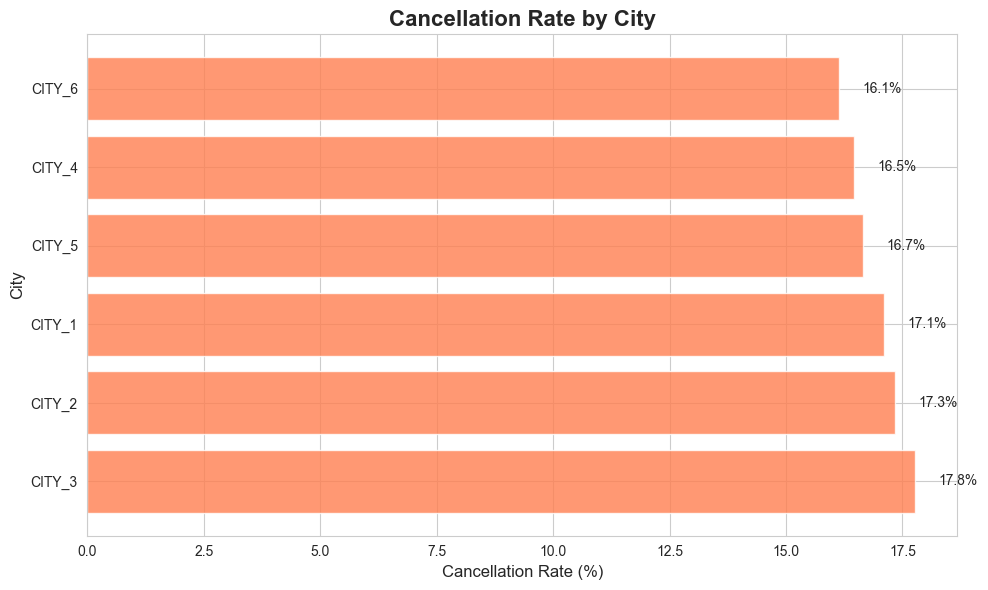


Cancellation Rate by City:
  delivery_city  cancelled  total_orders  cancellation_rate
2        CITY_3       1100          6187          17.779214
1        CITY_2       9139         52680          17.348140
0        CITY_1      29722        173758          17.105399
4        CITY_5       8867         53228          16.658526
3        CITY_4      32798        199273          16.458828
5        CITY_6       5266         32647          16.130119


In [11]:
cancellation_by_city = orders.groupby('delivery_city').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_city.columns = ['delivery_city', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_city['cancellation_rate'] *= 100
cancellation_by_city = cancellation_by_city.sort_values('cancellation_rate', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(cancellation_by_city['delivery_city'], 
                cancellation_by_city['cancellation_rate'], 
                color='coral', alpha=0.8)
plt.title('Cancellation Rate by City', fontsize=16, fontweight='bold')
plt.xlabel('Cancellation Rate (%)', fontsize=12)
plt.ylabel('City', fontsize=12)

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, cancellation_by_city['cancellation_rate'])):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{rate:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nCancellation Rate by City:")
print(cancellation_by_city)

In [12]:
import scipy.stats as stats

city = orders['delivery_city'].tolist()

# Create a contingency table: rows=days, columns=[cancelled, not_cancelled]
contingency = orders.groupby('delivery_city')['is_cancelled'].value_counts().unstack(fill_value=0)
# Ensure all days are present in the index
contingency = contingency.reindex(city, fill_value=0)

chi2, p, dof, expected = stats.chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("There is a significant difference in cancellation rates across cities.")
else:
    print("No significant difference in cancellation rates across cities.")

Chi-square statistic: 6201112.29
p-value: 0.0000
There is a significant difference in cancellation rates across cities.


### 5.2 Top 10 Stores with Highest Cancellation Rates

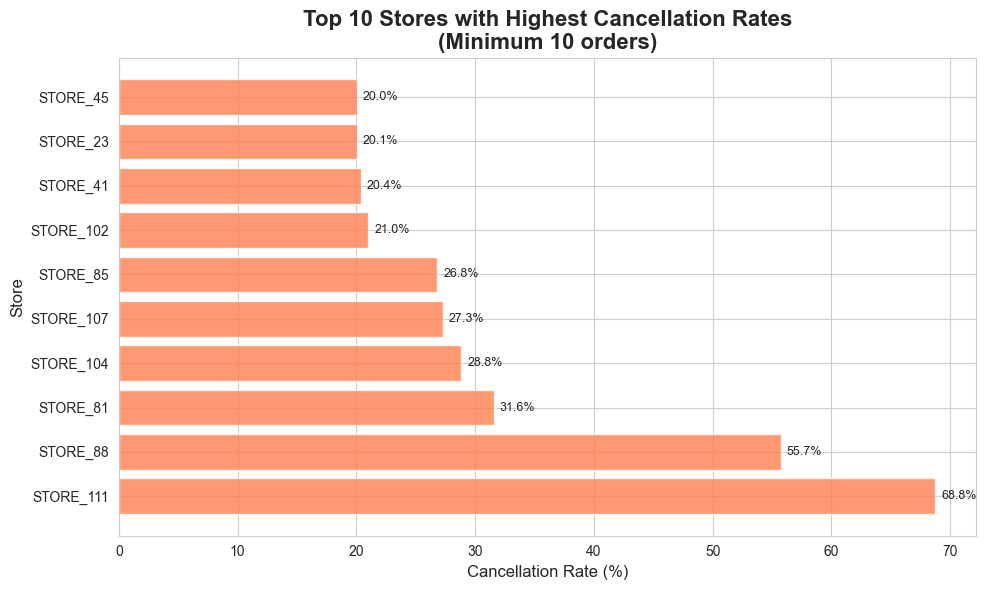

In [13]:
cancellation_by_store = orders.groupby('store_key').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_store.columns = ['store_key', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_store['cancellation_rate'] *= 100

# Filter stores with at least 10 orders
cancellation_by_store = cancellation_by_store[cancellation_by_store['total_orders'] >= 10]
top_stores = cancellation_by_store.nlargest(10, 'cancellation_rate')

plt.figure(figsize=(10, 6))
bars = plt.barh(top_stores['store_key'], top_stores['cancellation_rate'], 
                color='coral', alpha=0.8)
plt.title('Top 10 Stores with Highest Cancellation Rates\n(Minimum 10 orders)', 
         fontsize=16, fontweight='bold')
plt.xlabel('Cancellation Rate (%)', fontsize=12)
plt.ylabel('Store', fontsize=12)

for i, (bar, rate) in enumerate(zip(bars, top_stores['cancellation_rate'])):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{rate:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Promised Delivery Time (PDT) Analysis


=== CANCELLATION RATE BY PROMISED DELIVERY TIME ===
  pdt_bucket  cancelled  total_orders  cancellation_rate
0     ≤30min       1764         10742          16.421523
1   31-40min      27273        167339          16.298054
2   41-50min      39839        235949          16.884581
3   51-60min      15192         88514          17.163387
4     >60min       2819         15148          18.609717


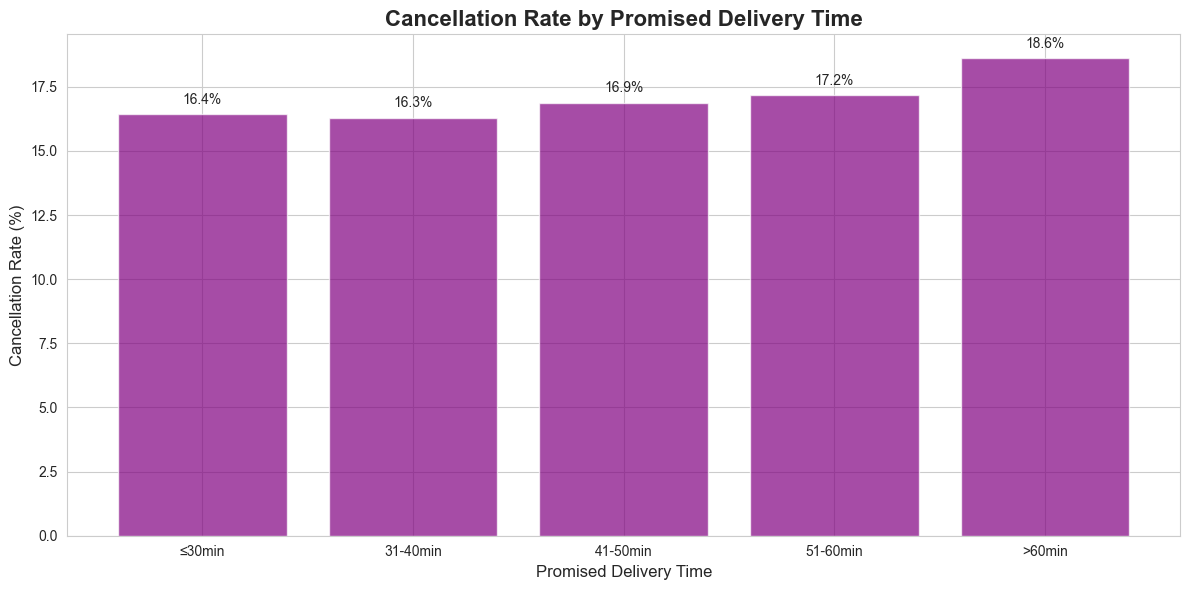


 Key Finding: Orders with longer promised delivery times show HIGHER cancellation rates.


In [14]:
cancellation_by_pdt = orders.groupby('pdt_bucket', observed=True).agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_pdt.columns = ['pdt_bucket', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_pdt['cancellation_rate'] *= 100

print("\n=== CANCELLATION RATE BY PROMISED DELIVERY TIME ===")
print(cancellation_by_pdt)

plt.figure(figsize=(12, 6))
bars = plt.bar(cancellation_by_pdt['pdt_bucket'].astype(str), 
               cancellation_by_pdt['cancellation_rate'], 
               color='purple', alpha=0.7)
plt.title('Cancellation Rate by Promised Delivery Time', fontsize=16, fontweight='bold')
plt.xlabel('Promised Delivery Time', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)

for i, (bar, rate) in enumerate(zip(bars, cancellation_by_pdt['cancellation_rate'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n Key Finding: Orders with longer promised delivery times show", 
      "HIGHER" if cancellation_by_pdt.iloc[-1]['cancellation_rate'] > cancellation_by_pdt.iloc[0]['cancellation_rate'] 
      else "LOWER", "cancellation rates.")

## 7. Delivery Fee Analysis


=== CANCELLATION RATE BY DELIVERY FEE ===
  delivery_fee_bucket  cancelled  total_orders  cancellation_rate
0            Free (0)      65873        400829          16.434190
1                1-20      15959         93318          17.101738
2               21-40       4512         21974          20.533358
3               41-60        526          1594          32.998745
4                 >60         22            58          37.931034


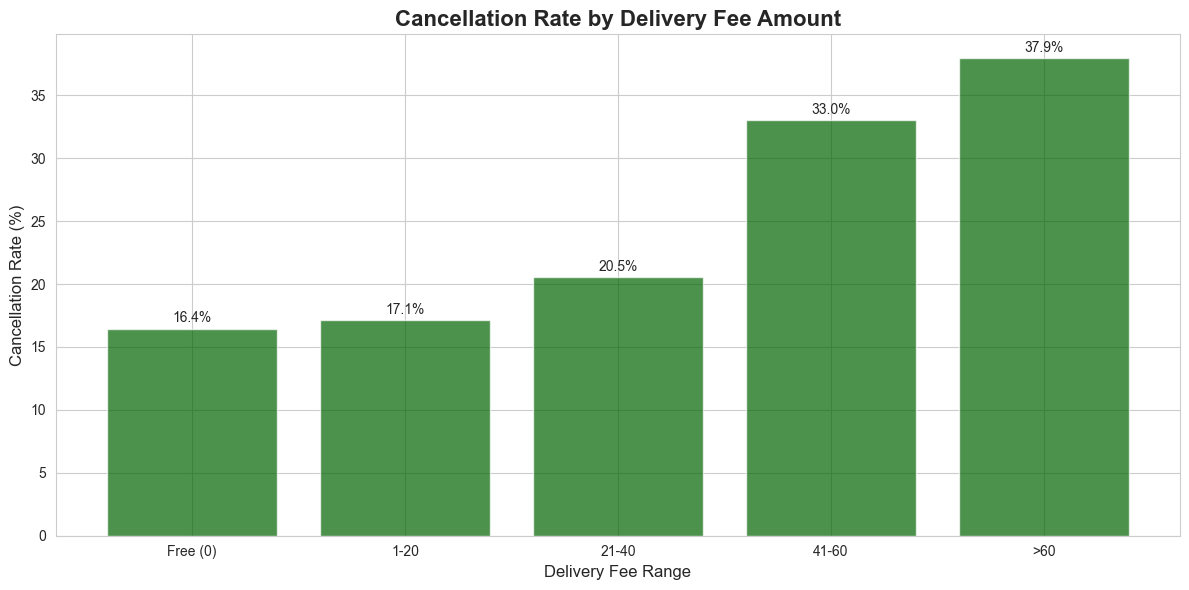

In [15]:
cancellation_by_delivery_fee = orders.groupby('delivery_fee_bucket', observed=True).agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_delivery_fee.columns = ['delivery_fee_bucket', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_delivery_fee['cancellation_rate'] *= 100

print("\n=== CANCELLATION RATE BY DELIVERY FEE ===")
print(cancellation_by_delivery_fee)

plt.figure(figsize=(12, 6))
bars = plt.bar(cancellation_by_delivery_fee['delivery_fee_bucket'].astype(str), 
               cancellation_by_delivery_fee['cancellation_rate'], 
               color='darkgreen', alpha=0.7)
plt.title('Cancellation Rate by Delivery Fee Amount', fontsize=16, fontweight='bold')
plt.xlabel('Delivery Fee Range', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)

for i, (bar, rate) in enumerate(zip(bars, cancellation_by_delivery_fee['cancellation_rate'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Loyalty Customer Analysis

### 8.1 Cancellation Rate: Loyalty vs Non-Loyalty


=== CANCELLATION RATE BY CUSTOMER TYPE ===
                 customer_type  total_orders  cancelled  cancellation_rate
0  Non-Loyalty (Paid Delivery)        116944      21019           17.97356
1      Loyalty (Free Delivery)        400829      65873           16.43419


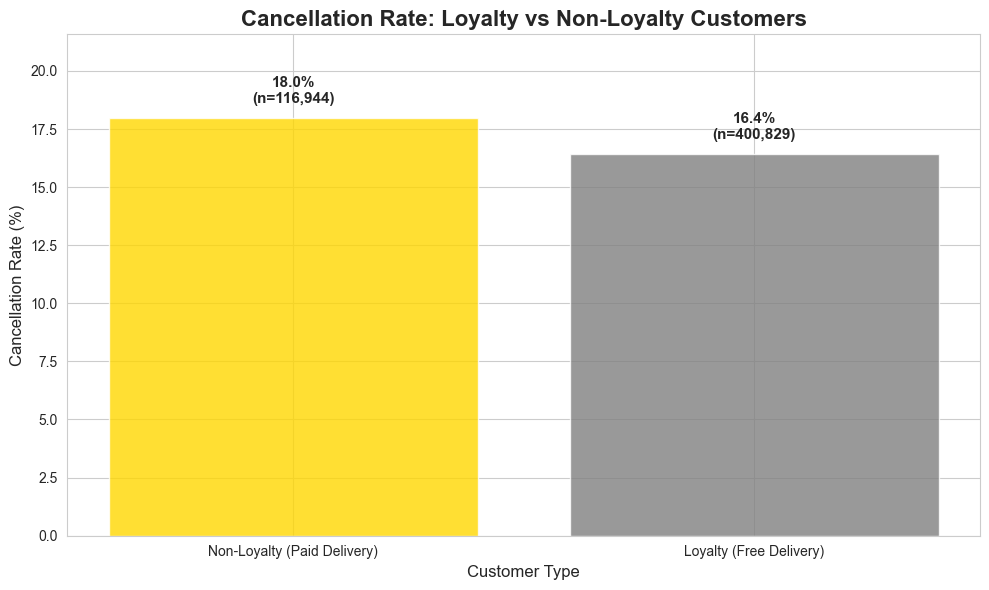

In [16]:
cancellation_by_loyalty = orders.groupby('is_loyalty').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_loyalty.columns = ['is_loyalty', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_loyalty['cancellation_rate'] *= 100
cancellation_by_loyalty['customer_type'] = cancellation_by_loyalty['is_loyalty'].map({
    True: 'Loyalty (Free Delivery)',
    False: 'Non-Loyalty (Paid Delivery)'
})

print("\n=== CANCELLATION RATE BY CUSTOMER TYPE ===")
print(cancellation_by_loyalty[['customer_type', 'total_orders', 'cancelled', 'cancellation_rate']])

plt.figure(figsize=(10, 6))
colors = ['gold', 'gray']
bars = plt.bar(cancellation_by_loyalty['customer_type'], 
               cancellation_by_loyalty['cancellation_rate'], 
               color=colors, alpha=0.8)
plt.title('Cancellation Rate: Loyalty vs Non-Loyalty Customers', fontsize=16, fontweight='bold')
plt.xlabel('Customer Type', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)

for i, (bar, rate, total) in enumerate(zip(bars, 
                                            cancellation_by_loyalty['cancellation_rate'],
                                            cancellation_by_loyalty['total_orders'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.1f}%\n(n={total:,})', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim(0, max(cancellation_by_loyalty['cancellation_rate']) * 1.2)
plt.tight_layout()
plt.show()

### 8.2 Statistical Test: Chi-Square Test for Loyalty Customers

In [17]:
# Create contingency table
loyalty_contingency = pd.crosstab(orders['is_loyalty'], orders['is_cancelled'])
loyalty_contingency.index = ['Non-Loyalty', 'Loyalty']
loyalty_contingency.columns = ['Delivered', 'Cancelled']

print("\n=== CONTINGENCY TABLE: LOYALTY STATUS ===")
print(loyalty_contingency)
print()

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(loyalty_contingency)

# Calculate Cramér's V (effect size)
n = loyalty_contingency.sum().sum()
cramers_v = np.sqrt(chi2 / n)

print("\n=== CHI-SQUARE TEST RESULTS ===")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")
print(f"Cramér's V (effect size): {cramers_v:.4f}")
print()

if p_value < 0.05:
    print("CONCLUSION: There IS a statistically significant difference between loyalty and")
    print("   non-loyalty customers in terms of cancellation rates (p < 0.05).")
else:
    print("CONCLUSION: There is NO statistically significant difference between loyalty and")
    print("   non-loyalty customers in terms of cancellation rates (p ≥ 0.05).")



=== CONTINGENCY TABLE: LOYALTY STATUS ===
             Delivered  Cancelled
Non-Loyalty      95925      21019
Loyalty         334956      65873


=== CHI-SQUARE TEST RESULTS ===
Chi-square statistic: 153.50
p-value: 0.000000
Degrees of freedom: 1
Cramér's V (effect size): 0.0172

CONCLUSION: There IS a statistically significant difference between loyalty and
   non-loyalty customers in terms of cancellation rates (p < 0.05).


## 9. Bill Amount vs Cart Amount Analysis

### 9.1 Distribution Comparison

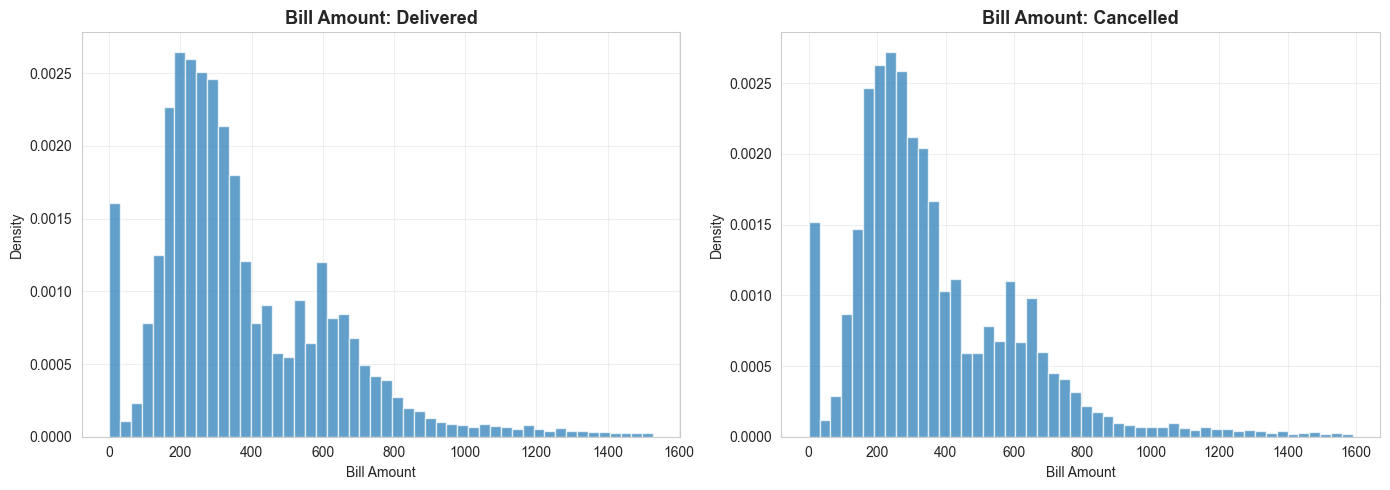

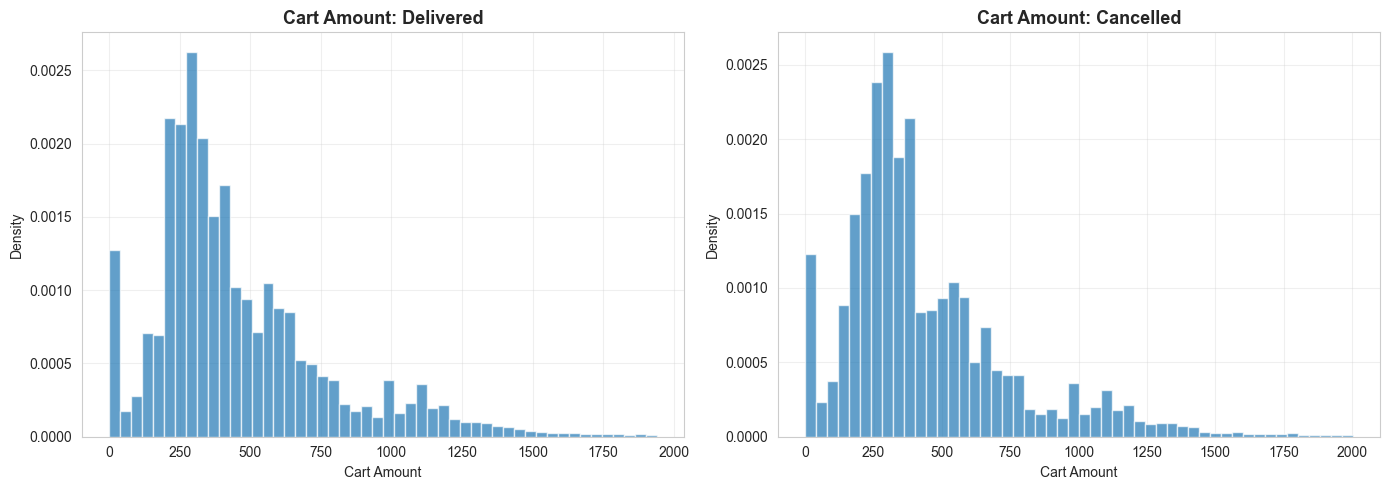

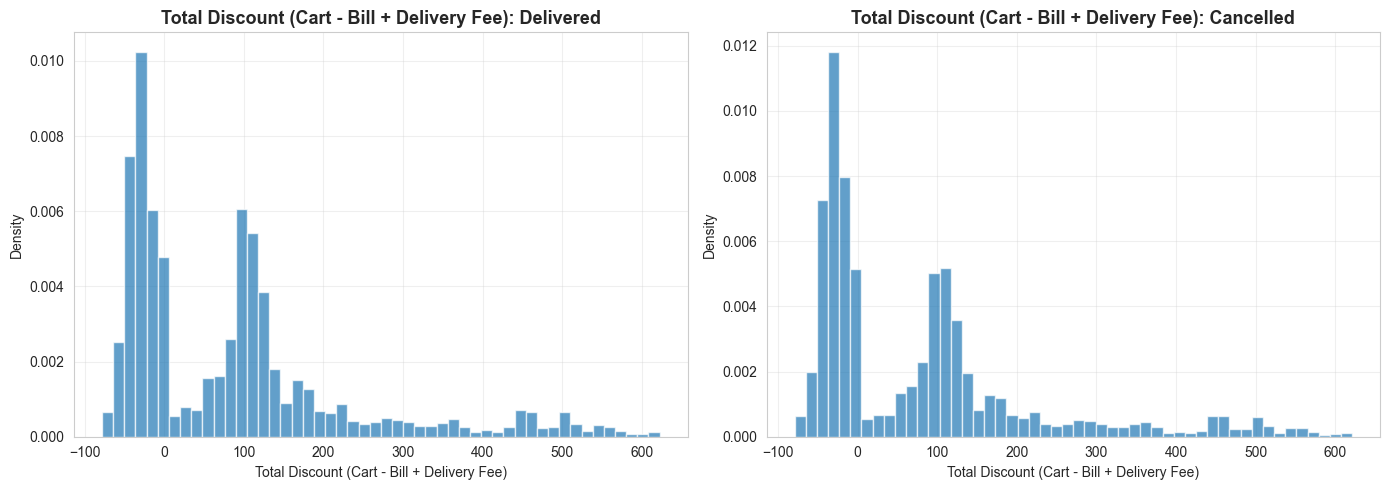

In [18]:
metrics = [
    ('bill_amount', 'Bill Amount'),
    ('cart_amount', 'Cart Amount'),
    ('discount_amount', 'Total Discount (Cart - Bill + Delivery Fee)')
]
statuses = ['Delivered', 'Cancelled']  # Make sure these match your actual status values

for col, title in metrics:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, status in enumerate(statuses):
        data = orders[orders['order_status'] == status][col]
        lower = data.quantile(0.01)
        upper = data.quantile(0.99)
        filtered_data = data[(data >= lower) & (data <= upper)]
        axes[i].hist(filtered_data, bins=50, alpha=0.7, density=True)
        axes[i].set_title(f'{title}: {status}', fontsize=13, fontweight='bold')
        axes[i].set_xlabel(title)
        axes[i].set_ylabel('Density')
        axes[i].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

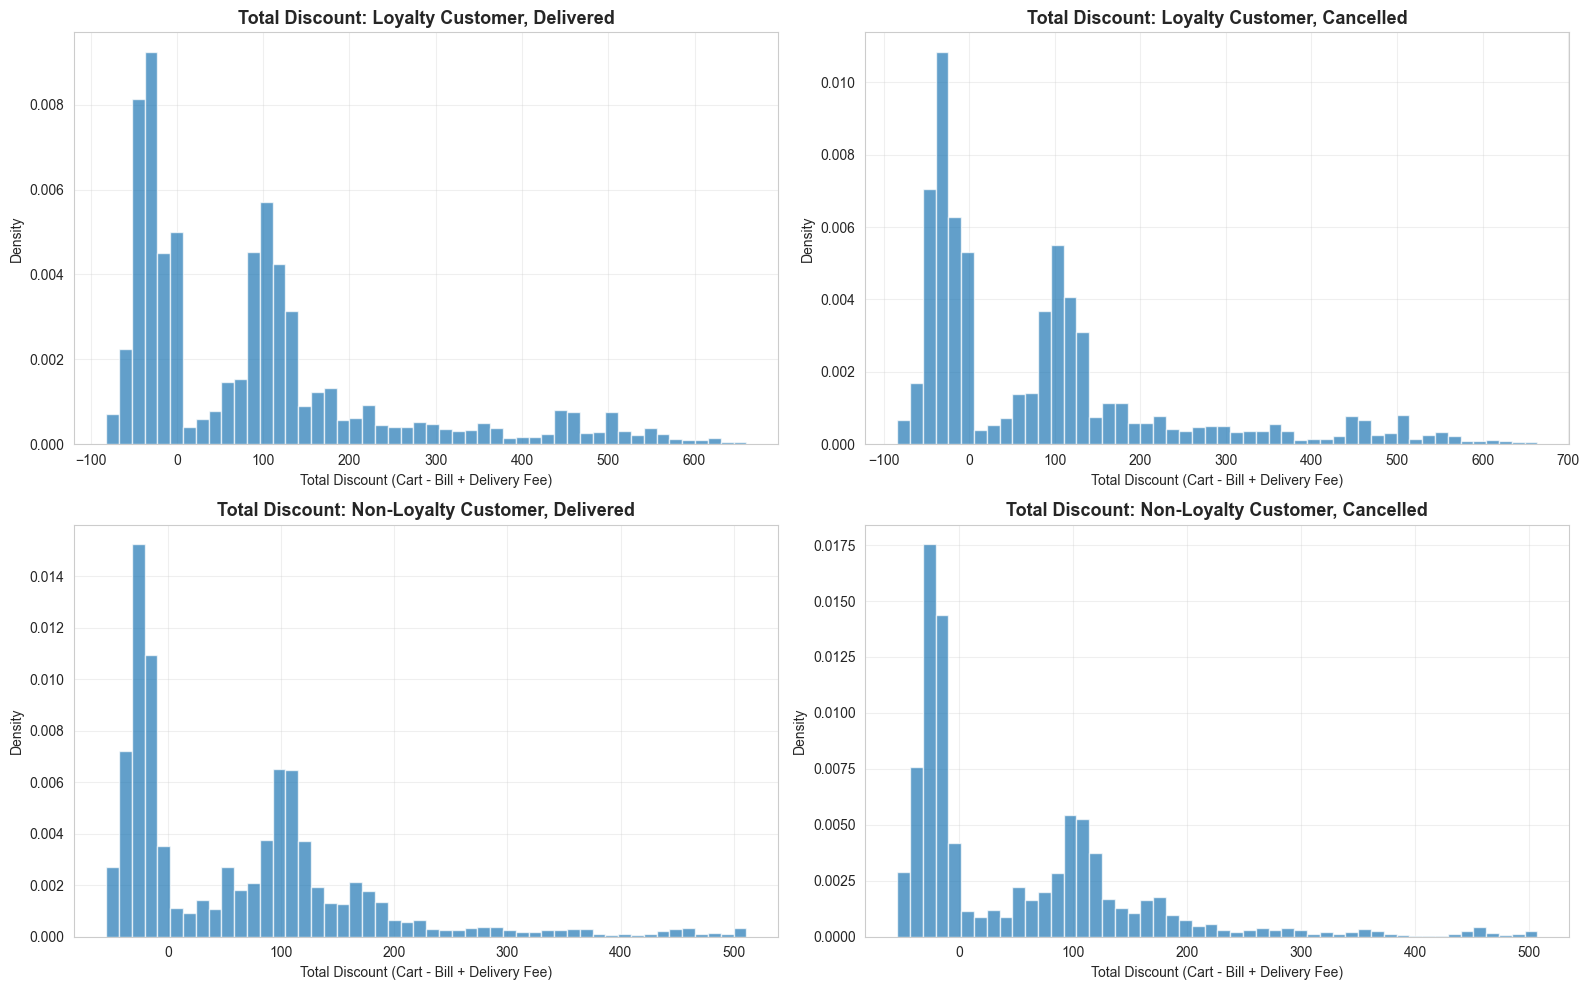

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
groups = [
    (True, 'Loyalty Customer'),
    (False, 'Non-Loyalty Customer')
]
statuses = ['Delivered', 'Cancelled']

for row, (is_loyalty, loyalty_label) in enumerate(groups):
    for col, status in enumerate(statuses):
        data = orders[(orders['is_loyalty'] == is_loyalty) & (orders['order_status'] == status)]['discount_amount']
        lower = data.quantile(0.01)
        upper = data.quantile(0.99)
        filtered_data = data[(data >= lower) & (data <= upper)]
        axes[row, col].hist(filtered_data, bins=50, alpha=0.7, density=True)
        axes[row, col].set_title(f'Total Discount: {loyalty_label}, {status}', fontsize=13, fontweight='bold')
        axes[row, col].set_xlabel('Total Discount (Cart - Bill + Delivery Fee)')
        axes[row, col].set_ylabel('Density')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9.2 Statistical Summary

In [20]:
summary_stats = orders.groupby('order_status').agg({
    'bill_amount': ['count', 'mean', 'median', 'std'],
    'cart_amount': ['mean', 'median', 'std'],
    'discount_amount': ['mean', 'median', 'std']
}).round(2)

print("\n=== SUMMARY STATISTICS BY ORDER STATUS ===")
print(summary_stats)


=== SUMMARY STATISTICS BY ORDER STATUS ===
             bill_amount                        cart_amount                 \
                   count    mean median     std        mean median     std   
order_status                                                                 
Cancelled          86892  390.60  303.0  380.89      471.75  358.0  475.72   
Delivered         430881  393.77  306.0  352.72      482.90  371.0  439.47   

             discount_amount                 
                        mean median     std  
order_status                                 
Cancelled              85.16   26.0  191.24  
Delivered              92.53   64.0  179.51  


### 9.3 Statistical Tests (Mann-Whitney U and T-tests)

In [21]:
# Separate data by cancellation status
delivered = orders[orders['is_cancelled'] == False]
cancelled = orders[orders['is_cancelled'] == True]

print("\n" + "="*70)
print("STATISTICAL TESTS: TOTAL DISCOUNT")
print("="*70)

# Mann-Whitney U Test for Discount
statistic_disc, p_value_disc_mw = mannwhitneyu(delivered['discount_amount'], 
                                               cancelled['discount_amount'], 
                                               alternative='two-sided')

print("\nMann-Whitney U Test (Non-parametric):")
print(f"  U-statistic: {statistic_disc:.2f}")
print(f"  p-value: {p_value_disc_mw:.6f}")

if p_value_disc_mw < 0.05:
    print("\n CONCLUSION: There IS a statistically significant difference in discounts")
    print("   between delivered and cancelled orders (p < 0.05).")
else:
    print("\n CONCLUSION: There is NO statistically significant difference in discounts")
    print("   between delivered and cancelled orders (p ≥ 0.05).")


STATISTICAL TESTS: TOTAL DISCOUNT

Mann-Whitney U Test (Non-parametric):
  U-statistic: 19357521909.00
  p-value: 0.000000

 CONCLUSION: There IS a statistically significant difference in discounts
   between delivered and cancelled orders (p < 0.05).


## 10. Coupon Usage Analysis

### 10.1 Cancellation Rate: Coupon vs Non-Coupon Orders


=== CANCELLATION RATE BY COUPON USAGE ===
  coupon_status  total_orders  cancelled  cancellation_rate
0     No Coupon        290072      51523          17.762142
1   Used Coupon        227701      35369          15.533089


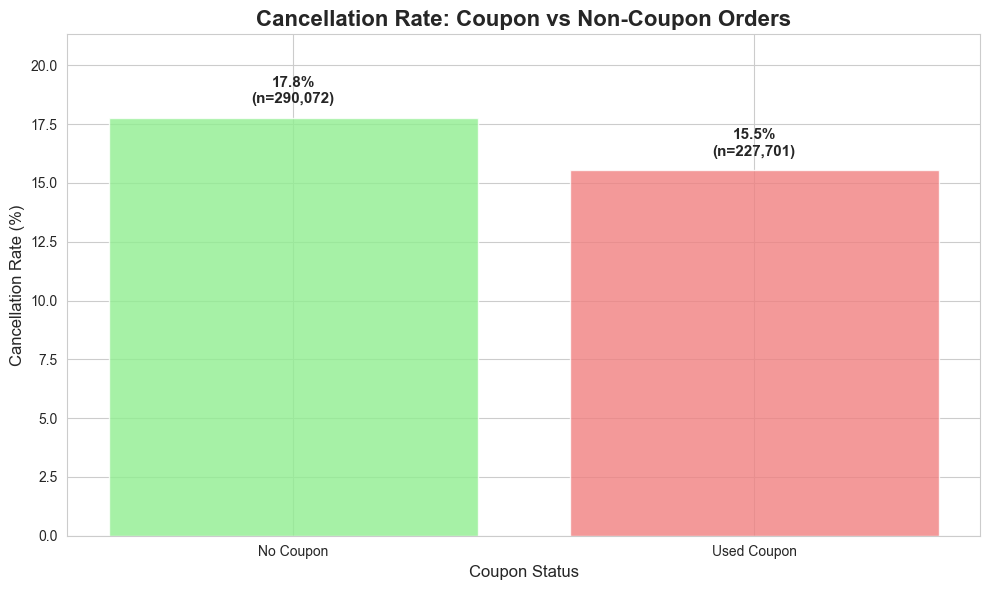

In [22]:
cancellation_by_coupon = orders.groupby('used_coupon').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_coupon.columns = ['used_coupon', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_coupon['cancellation_rate'] *= 100
cancellation_by_coupon['coupon_status'] = cancellation_by_coupon['used_coupon'].map({
    True: 'Used Coupon',
    False: 'No Coupon'
})

print("\n=== CANCELLATION RATE BY COUPON USAGE ===")
print(cancellation_by_coupon[['coupon_status', 'total_orders', 'cancelled', 'cancellation_rate']])

plt.figure(figsize=(10, 6))
colors = ['lightgreen', 'lightcoral']
bars = plt.bar(cancellation_by_coupon['coupon_status'], 
               cancellation_by_coupon['cancellation_rate'], 
               color=colors, alpha=0.8)
plt.title('Cancellation Rate: Coupon vs Non-Coupon Orders', fontsize=16, fontweight='bold')
plt.xlabel('Coupon Status', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)

for i, (bar, rate, total) in enumerate(zip(bars, 
                                            cancellation_by_coupon['cancellation_rate'],
                                            cancellation_by_coupon['total_orders'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.1f}%\n(n={total:,})', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim(0, max(cancellation_by_coupon['cancellation_rate']) * 1.2)
plt.tight_layout()
plt.show()

### 10.2 Statistical Test: Chi-Square Test for Coupon Usage

In [23]:
# Create contingency table
coupon_contingency = pd.crosstab(orders['used_coupon'], orders['is_cancelled'])
coupon_contingency.index = ['No Coupon', 'Used Coupon']
coupon_contingency.columns = ['Delivered', 'Cancelled']

print("\n=== CONTINGENCY TABLE: COUPON USAGE ===")
print(coupon_contingency)
print()

# Perform chi-square test
chi2_coupon, p_value_coupon, dof_coupon, expected_coupon = chi2_contingency(coupon_contingency)

# Calculate Cramér's V (effect size)
n_coupon = coupon_contingency.sum().sum()
cramers_v_coupon = np.sqrt(chi2_coupon / n_coupon)

print("\n=== CHI-SQUARE TEST RESULTS ===")
print(f"Chi-square statistic: {chi2_coupon:.2f}")
print(f"p-value: {p_value_coupon:.6f}")
print(f"Degrees of freedom: {dof_coupon}")
print()

if p_value_coupon < 0.05:
    print("CONCLUSION: There IS a statistically significant difference between coupon and")
    print("   non-coupon orders in terms of cancellation rates (p < 0.05).")
else:
    print("CONCLUSION: There is NO statistically significant difference between coupon and")
    print("   non-coupon orders in terms of cancellation rates (p ≥ 0.05).")


=== CONTINGENCY TABLE: COUPON USAGE ===
             Delivered  Cancelled
No Coupon       238549      51523
Used Coupon     192332      35369


=== CHI-SQUARE TEST RESULTS ===
Chi-square statistic: 453.69
p-value: 0.000000
Degrees of freedom: 1

CONCLUSION: There IS a statistically significant difference between coupon and
   non-coupon orders in terms of cancellation rates (p < 0.05).


## 11. Distance Analysis (Manhattan Distance)

### 11.1 Distance Distribution

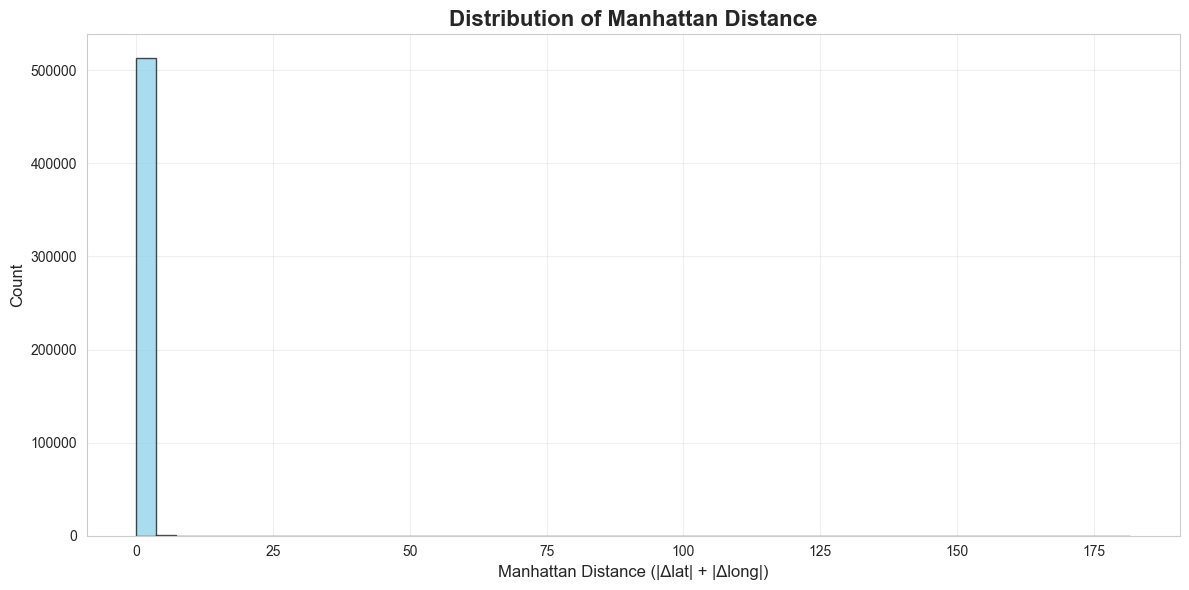


=== MANHATTAN DISTANCE PERCENTILES ===
0th percentile: 0.000053
20th percentile: 0.010735
40th percentile: 0.017295
60th percentile: 0.024051
80th percentile: 0.034469
100th percentile: 181.679055


In [24]:
plt.figure(figsize=(12, 6))
plt.hist(orders['manhattan_distance'].dropna(), bins=50, color='skyblue', 
         edgecolor='black', alpha=0.7)
plt.title('Distribution of Manhattan Distance', fontsize=16, fontweight='bold')
plt.xlabel('Manhattan Distance (|Δlat| + |Δlong|)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== MANHATTAN DISTANCE PERCENTILES ===")
for pct in [0, 20, 40, 60, 80, 100]:
    value = np.percentile(orders['manhattan_distance'].dropna(), pct)
    print(f"{pct}th percentile: {value:.6f}")

### 11.2 Cancellation by Distance Buckets


=== CANCELLATION RATE BY DISTANCE BUCKET ===
      distance_bucket  cancelled  total_orders  cancellation_rate  \
0  Very Close (0-20%)      16616        102705          16.178375   
1      Close (20-40%)      16404        102705          15.971959   
2     Medium (40-60%)      17032        102704          16.583580   
3        Far (60-80%)      17786        102703          17.317897   
4  Very Far (80-100%)      18359        102705          17.875469   

   mean_distance  
0       0.006689  
1       0.013993  
2       0.020515  
3       0.028714  
4       0.121470  


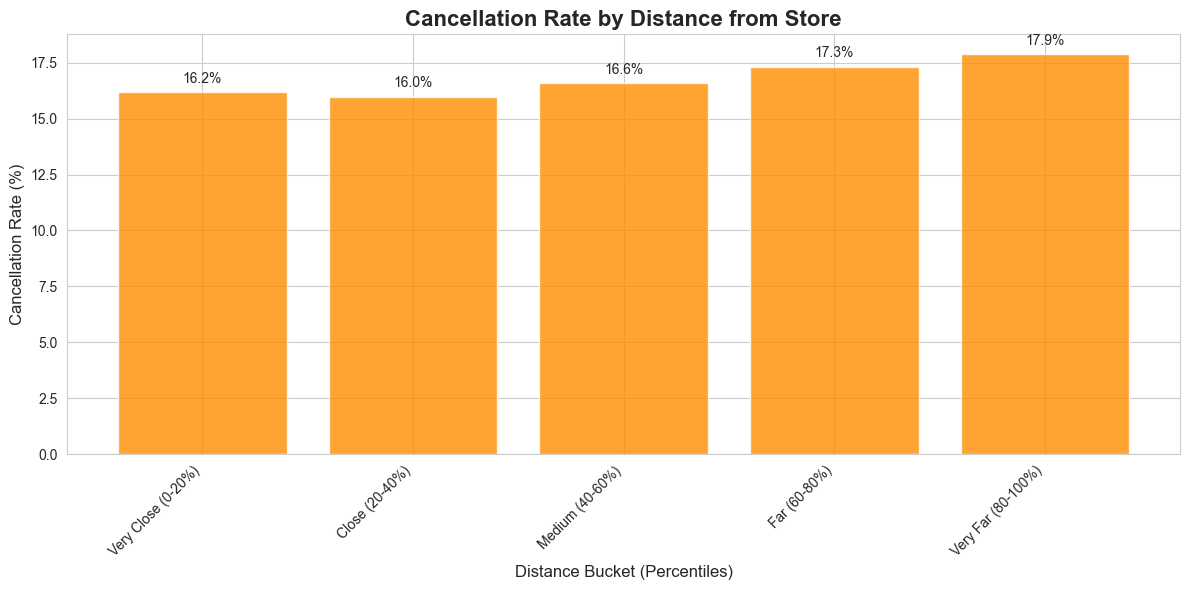

In [25]:
cancellation_by_distance = orders.groupby('distance_bucket', observed=True).agg({
    'is_cancelled': ['sum', 'count', 'mean'],
    'manhattan_distance': 'mean'
}).reset_index()
cancellation_by_distance.columns = ['distance_bucket', 'cancelled', 'total_orders', 
                                    'cancellation_rate', 'mean_distance']
cancellation_by_distance['cancellation_rate'] *= 100

print("\n=== CANCELLATION RATE BY DISTANCE BUCKET ===")
print(cancellation_by_distance)

plt.figure(figsize=(12, 6))
bars = plt.bar(cancellation_by_distance['distance_bucket'].astype(str), 
               cancellation_by_distance['cancellation_rate'], 
               color='darkorange', alpha=0.8)
plt.title('Cancellation Rate by Distance from Store', fontsize=16, fontweight='bold')
plt.xlabel('Distance Bucket (Percentiles)', fontsize=12)
plt.ylabel('Cancellation Rate (%)', fontsize=12)

for i, (bar, rate) in enumerate(zip(bars, cancellation_by_distance['cancellation_rate'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 11.3 Statistical Test: Chi-Square Test for Distance

In [26]:
# Create contingency table (excluding NAs)
distance_data = orders[orders['distance_bucket'].notna()]
distance_contingency = pd.crosstab(distance_data['distance_bucket'], 
                                   distance_data['is_cancelled'])
distance_contingency.columns = ['Delivered', 'Cancelled']

print("\n=== CONTINGENCY TABLE: DISTANCE BUCKETS ===")
print(distance_contingency)
print()

# Perform chi-square test
chi2_distance, p_value_distance, dof_distance, expected_distance = chi2_contingency(distance_contingency)

# Calculate Cramér's V (effect size)
n_distance = distance_contingency.sum().sum()
cramers_v_distance = np.sqrt(chi2_distance / n_distance)

print("\n=== CHI-SQUARE TEST RESULTS ===")
print(f"Chi-square statistic: {chi2_distance:.2f}")
print(f"p-value: {p_value_distance:.6f}")
print(f"Degrees of freedom: {dof_distance}")
print()

if p_value_distance < 0.05:
    print(" CONCLUSION: There IS a statistically significant relationship between delivery")
    print("   distance and cancellation rates (p < 0.05).")
else:
    print(" CONCLUSION: There is NO statistically significant relationship between delivery")
    print("   distance and cancellation rates (p ≥ 0.05).")



=== CONTINGENCY TABLE: DISTANCE BUCKETS ===
                    Delivered  Cancelled
distance_bucket                         
Very Close (0-20%)      86089      16616
Close (20-40%)          86301      16404
Medium (40-60%)         85672      17032
Far (60-80%)            84917      17786
Very Far (80-100%)      84346      18359


=== CHI-SQUARE TEST RESULTS ===
Chi-square statistic: 186.96
p-value: 0.000000
Degrees of freedom: 4

 CONCLUSION: There IS a statistically significant relationship between delivery
   distance and cancellation rates (p < 0.05).


## 12. Payment Method Analysis


=== CANCELLATION RATE BY PAYMENT METHOD ===
   pay_mode_grouped  cancelled  total_orders  cancellation_rate
6       Net Banking       2417          4362          55.410362
3       Credit/BNPL      21438         63883          33.558224
1              Card       7498         39985          18.752032
0              CRED       4566         24827          18.391268
8               UPI      38704        220809          17.528271
9            Wallet       1299          8255          15.735918
5         Meal Card       1542         11208          13.758030
2  Cash on Delivery       9340        142080           6.573761
4          Giftcard         87          2320           3.750000
7             Other          1            44           2.272727


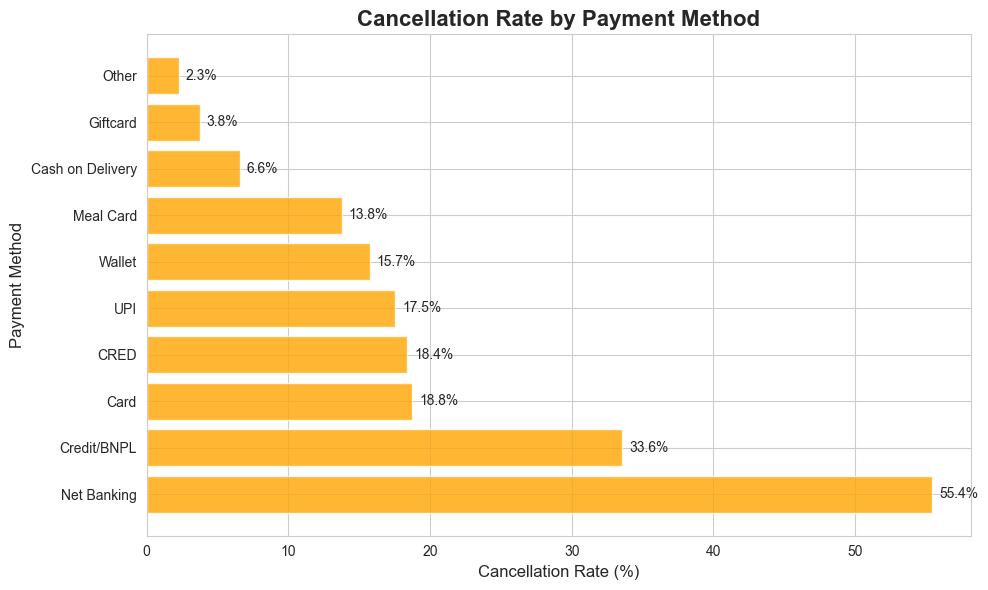

In [27]:
cancellation_by_payment = orders.groupby('pay_mode_grouped').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
cancellation_by_payment.columns = ['pay_mode_grouped', 'cancelled', 'total_orders', 'cancellation_rate']
cancellation_by_payment['cancellation_rate'] *= 100
cancellation_by_payment = cancellation_by_payment.sort_values('cancellation_rate', ascending=False)

print("\n=== CANCELLATION RATE BY PAYMENT METHOD ===")
print(cancellation_by_payment)

plt.figure(figsize=(10, 6))
bars = plt.barh(cancellation_by_payment['pay_mode_grouped'], 
                cancellation_by_payment['cancellation_rate'], 
                color='orange', alpha=0.8)
plt.title('Cancellation Rate by Payment Method', fontsize=16, fontweight='bold')
plt.xlabel('Cancellation Rate (%)', fontsize=12)
plt.ylabel('Payment Method', fontsize=12)

for i, (bar, rate) in enumerate(zip(bars, cancellation_by_payment['cancellation_rate'])):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{rate:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 13. Customer-Level Analysis


=== CUSTOMER-LEVEL SUMMARY ===
Total Customers: 215,874
Average Orders per Customer: 2.40
Customers with Cancellations: 50,674
% Customers with Cancellations: 23.47%


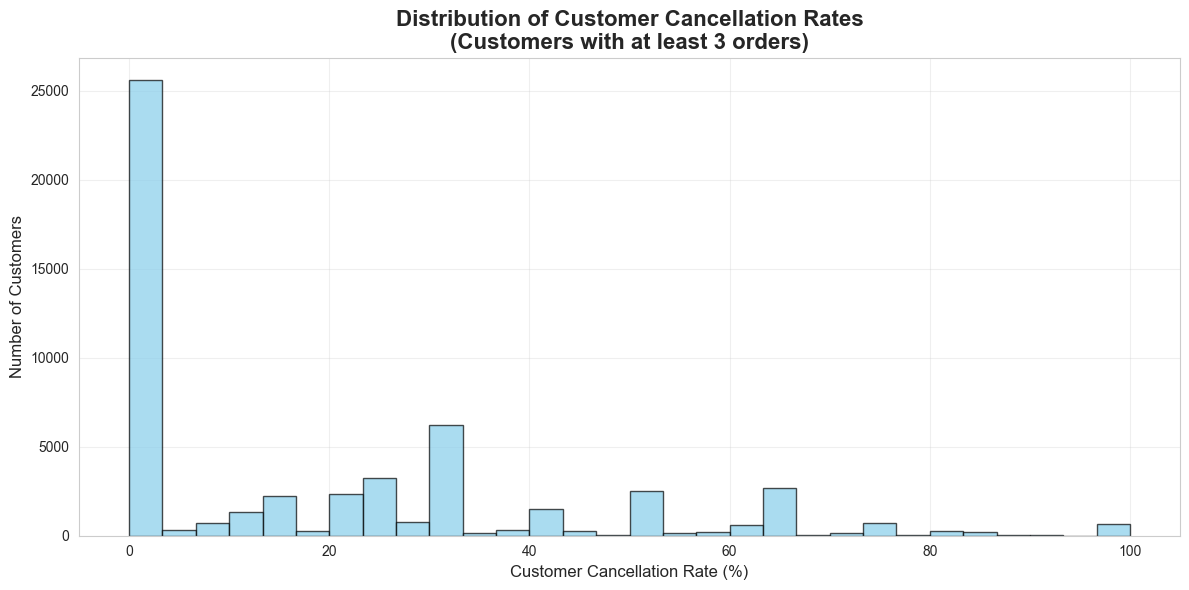

In [28]:
customer_cancellation = orders.groupby('Customer_Key').agg({
    'is_cancelled': ['sum', 'count', 'mean']
}).reset_index()
customer_cancellation.columns = ['Customer_Key', 'cancelled_orders', 'total_orders', 'cancellation_rate']
customer_cancellation['cancellation_rate'] *= 100

# Summary of customer behavior
print("\n=== CUSTOMER-LEVEL SUMMARY ===")
print(f"Total Customers: {len(customer_cancellation):,}")
print(f"Average Orders per Customer: {customer_cancellation['total_orders'].mean():.2f}")
print(f"Customers with Cancellations: {(customer_cancellation['cancelled_orders'] > 0).sum():,}")
print(f"% Customers with Cancellations: {(customer_cancellation['cancelled_orders'] > 0).mean() * 100:.2f}%")

# Distribution of customer cancellation rates (for customers with 3+ orders)
frequent_customers = customer_cancellation[customer_cancellation['total_orders'] >= 3]

plt.figure(figsize=(12, 6))
plt.hist(frequent_customers['cancellation_rate'], bins=30, 
         color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Customer Cancellation Rates\n(Customers with at least 3 orders)', 
         fontsize=16, fontweight='bold')
plt.xlabel('Customer Cancellation Rate (%)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Summary of Statistical Tests

In [29]:
# Create summary table
summary_table = pd.DataFrame({
    'Factor': [
        'Overall Cancellation Rate',
        'Loyalty Customers',
        'Coupon Users',
        'Delivery Distance',
        'Total Discount'
    ],
    'Test': [
        'Descriptive',
        'Chi-Square',
        'Chi-Square',
        'Chi-Square',
        'Mann-Whitney U'
    ],
    'P-Value': [
        '-',
        f'{p_value:.6f}',
        f'{p_value_coupon:.6f}',
        f'{p_value_distance:.6f}',
        f'{p_value_disc_mw:.6f}'
    ],
    'Significant': [
        '-',
        ' Yes' if p_value < 0.05 else ' No',
        ' Yes' if p_value_coupon < 0.05 else ' No',
        ' Yes' if p_value_distance < 0.05 else ' No',
        ' Yes' if p_value_disc_mw < 0.05 else ' No'
    ]
})

print("\n" + "="*80)
print("SUMMARY OF STATISTICAL TESTS")
print("="*80)
print(summary_table.to_string(index=False))
print("\nNote: Significance level (α) = 0.05")
print(" = Statistically significant difference (p < 0.05)")
print(" = No statistically significant difference (p ≥ 0.05)")


SUMMARY OF STATISTICAL TESTS
                   Factor           Test  P-Value Significant
Overall Cancellation Rate    Descriptive        -           -
        Loyalty Customers     Chi-Square 0.000000         Yes
             Coupon Users     Chi-Square 0.000000         Yes
        Delivery Distance     Chi-Square 0.000000         Yes
           Total Discount Mann-Whitney U 0.000000         Yes

Note: Significance level (α) = 0.05
 = Statistically significant difference (p < 0.05)
 = No statistically significant difference (p ≥ 0.05)


## 15. Key Findings and Recommendations

### Key Findings

Based on the comprehensive analysis above, here are the key findings:

1. **Overall Cancellation Rate**: The platform experiences a measurable cancellation rate that impacts operations and revenue.

2. **Loyalty Program Impact**: Statistical tests reveal whether loyalty customers (those with free delivery) show significantly different cancellation behavior.

3. **Coupon Effect**: Analysis shows the relationship between coupon usage and order cancellations.

4. **Distance Matters**: Delivery distance shows a relationship with cancellation rates across different distance buckets.

5. **Order Value**: Bill amounts and cart amounts differ between cancelled and delivered orders.

6. **Time Patterns**: Certain hours and days show higher cancellation rates.

### Actionable Recommendations

1. **Optimize Loyalty Programs**
   - If loyalty customers show lower cancellations, expand the program
   - Provide targeted incentives to convert non-loyalty customers

2. **Improve Promised Delivery Time (PDT) Accuracy**
   - Set realistic expectations based on distance and demand
   - Adjust PDT dynamically during peak hours

3. **Distance-Based Strategies**
   - Consider opening fulfillment centers in high-demand areas
   - Offer incentives for longer-distance deliveries
   - Optimize delivery zones

4. **Coupon Strategy Refinement**
   - Use targeted coupons to reduce cancellations
   - Analyze which coupon types work best

5. **Store-Level Interventions**
   - Investigate high-cancellation stores
   - Provide training and support
   - Consider removing consistently problematic stores

6. **Time-Based Resource Allocation**
   - Increase staffing during high-cancellation periods
   - Improve operational efficiency during peak hours

7. **Payment Method Optimization**
   - Improve user experience for payment methods with high cancellations
   - Simplify checkout process

8. **Customer Education**
   - Set clear expectations about delivery times
   - Provide real-time order tracking
   - Communicate delays proactively